In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.ensemble import VotingRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

2021-12-24 20:35:55.513938: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
path = 'Dataset3/'
x1_train = pd.read_csv(path+'data_trainmid_x1.csv')
x2_train = pd.read_csv(path+'data_trainmid_x2.csv')
f1_train = pd.read_csv(path+'data_trainmid_f1.csv')
f1_test = pd.read_csv(path+'data_testmid_f1.csv')
x1_test = pd.read_csv(path+'data_testmid_x1.csv')
x2_test = pd.read_csv(path+'data_testmid_x2.csv')
print(len(x1_train),len(x1_test),len(f1_train),len(f1_test))
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1),columns = ['p1','p2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1),columns = ['p1','p2'])
X_train.head()

112459 62211 112459 62211


,p1,p2
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [3]:
from scipy import *
from scipy.linalg import norm, pinv
import math
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [12]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    '''
    importances = rf.feature_importances_
    plt.figure(figsize=(20,5))
    x_plot = ['x1(n{})'.format(-i) for i in range(0,m*t,t)] + ['x2(n{})'.format(-i) for i in range(0,m*t,t)]
    plt.plot(x_plot,importances, label = 'Importance Plot')
    plt.legend()
    plt.xlabel('Feature')
    plt.ylabel('Feature importance')
    plt.title('Importance plot for random forest')
    plt.show()'''
    
    # RBF MODEL
    rbf = RBF(2*m, 10*m, 1)
    t1 = datetime.now()
    rbf.train(x_train, y_train)
    t2 = datetime.now()
    
    print('\n\nTime taken by RBF Model: ',t2-t1)
    y1_pred = rbf.test(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    
    # SVR MODEL
    t1 = datetime.now()
    clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    # COMPARISON
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF')
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error7, label = 'Error of SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error7[:6000], label = 'SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

# Current Positions

Time taken by Random Forest 0:00:21.788927
Root Mean Squared error of Random Forest 0.07582442117758005
Minimum Error = 2.6666666666768507e-06
Maximum Error = 0.9093420000000012
Median Value of Error = 0.03448699999999982


Time taken by RBF Model:  0:00:07.666830
Root mean square error of RBF Model:  0.10232173754733093
Minimum Error = [5.75107516e-08]
Maximum Error = [0.97585153]
Median Value of Error = [0.07382671]


Time taken by SVR Model:  0:01:17.107703
Root mean square error of SVR Model:  0.055984382601127106
Minimum Error = 3.6805600940326144e-06
Maximum Error = 0.7107838977392054
Median Value of Error = 0.03498624132669281


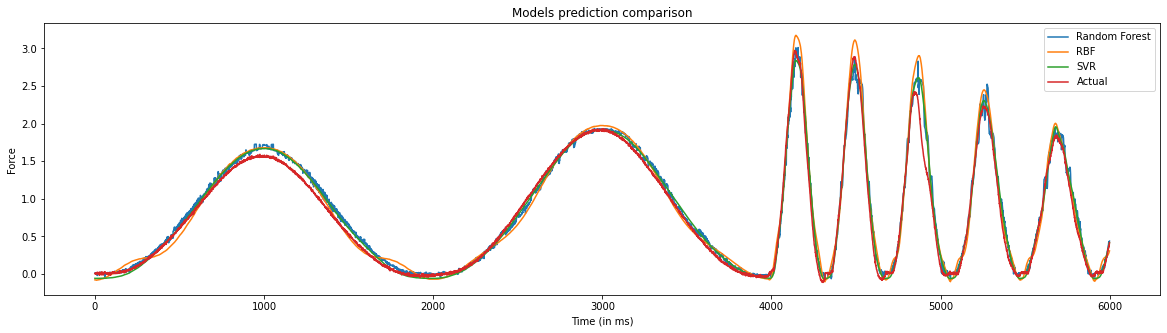

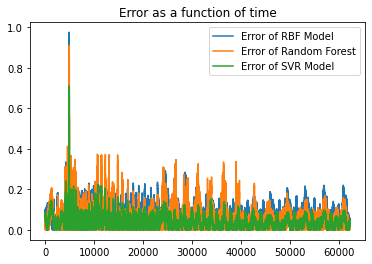

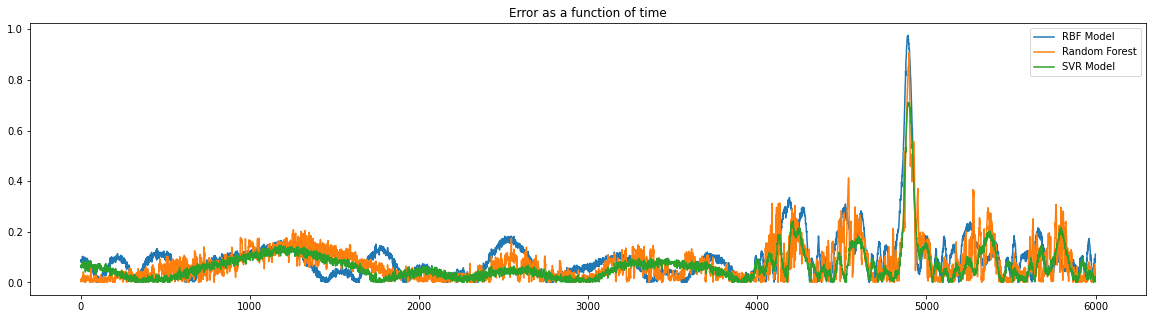

In [13]:
get_results(t=0, m=1)

# Six stages of past inputs

Time taken by Random Forest 0:00:58.905180
Root Mean Squared error of Random Forest 0.060494638432792534
Minimum Error = 6.938893903907228e-18
Maximum Error = 0.918622000000002
Median Value of Error = 0.019465999999999983


Time taken by RBF Model:  0:00:22.969820
Root mean square error of RBF Model:  0.0631506229734045
Minimum Error = [2.94447759e-07]
Maximum Error = [0.72571401]
Median Value of Error = [0.03312493]


Time taken by SVR Model:  0:00:38.199965
Root mean square error of SVR Model:  0.052229884360948685
Minimum Error = 4.9456490347488113e-08
Maximum Error = 0.6888342849596538
Median Value of Error = 0.03268404620088594


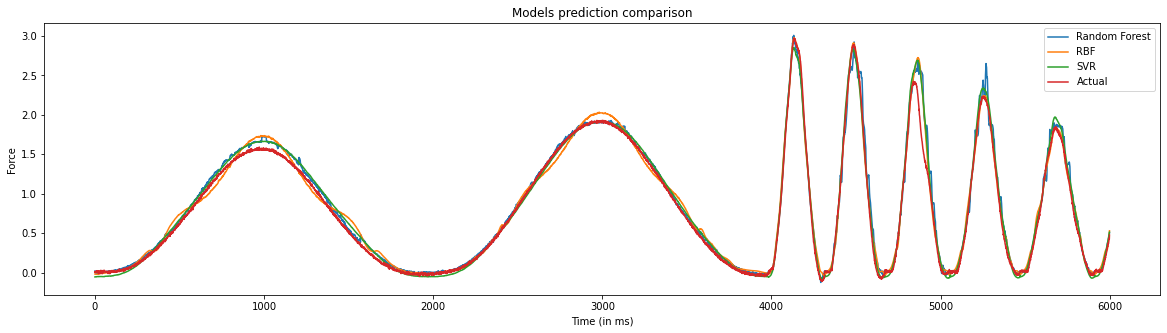

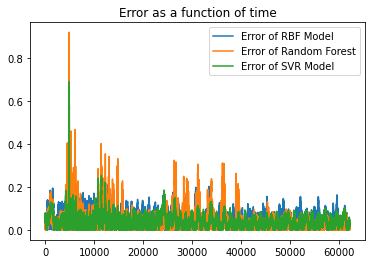

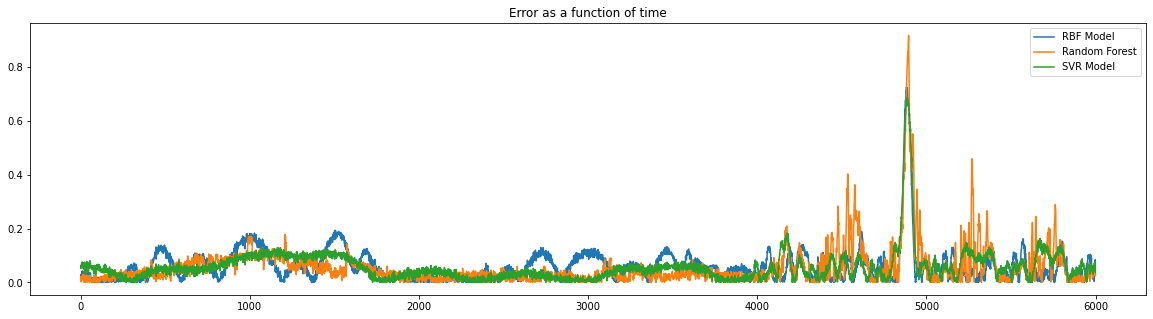

In [14]:
get_results(t=2, m=3)

Time taken by Random Forest 0:01:56.644754
Root Mean Squared error of Random Forest 0.059361233311719275
Minimum Error = 0.0
Maximum Error = 0.9006010000000024
Median Value of Error = 0.01878200000000052


Time taken by RBF Model:  0:00:45.983943
Root mean square error of RBF Model:  0.04814866116795736
Minimum Error = [1.06920571e-06]
Maximum Error = [0.65091874]
Median Value of Error = [0.0215931]


Time taken by SVR Model:  0:00:38.052900
Root mean square error of SVR Model:  0.05032844131323425
Minimum Error = 3.9406353108395464e-07
Maximum Error = 0.7033726623192846
Median Value of Error = 0.030082582839258687


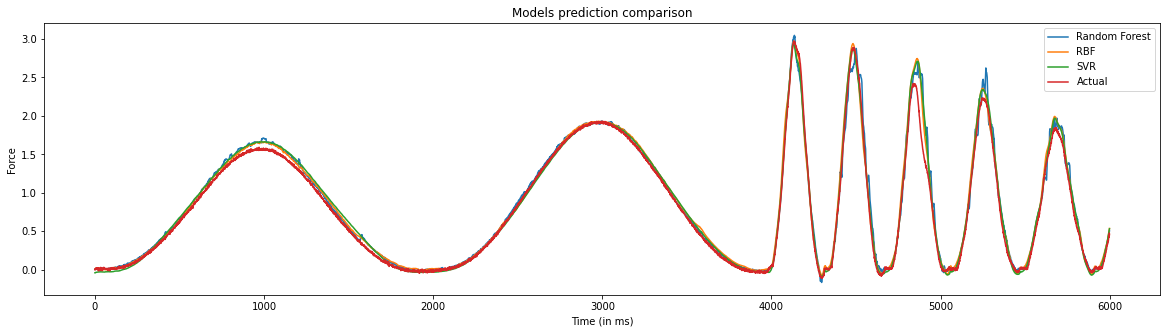

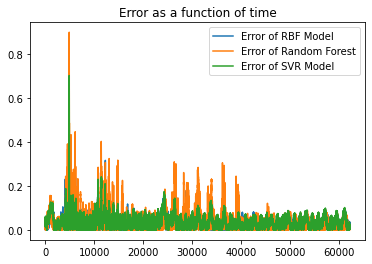

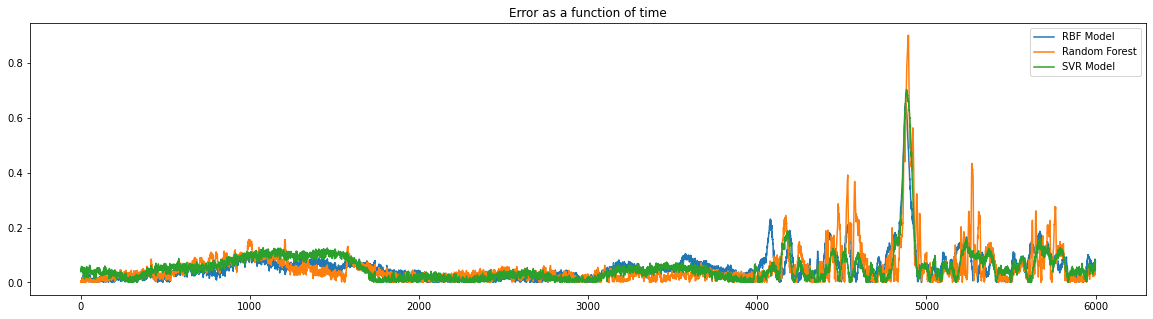

In [16]:
get_results(t=1,m=6)

Time taken by Random Forest 0:00:40.963680
Root Mean Squared error of Random Forest 0.06289558201209546
Minimum Error = 1.0842021724855044e-18
Maximum Error = 0.9226019999999997
Median Value of Error = 0.021221999999999998


Time taken by RBF Model:  0:00:15.779856
Root mean square error of RBF Model:  0.0782304427803603
Minimum Error = [1.45209998e-06]
Maximum Error = [0.80811845]
Median Value of Error = [0.040439]


Time taken by SVR Model:  0:00:31.656670
Root mean square error of SVR Model:  0.052325179124678316
Minimum Error = 1.4075673582247816e-07
Maximum Error = 0.6970875298690633
Median Value of Error = 0.03304713465687403


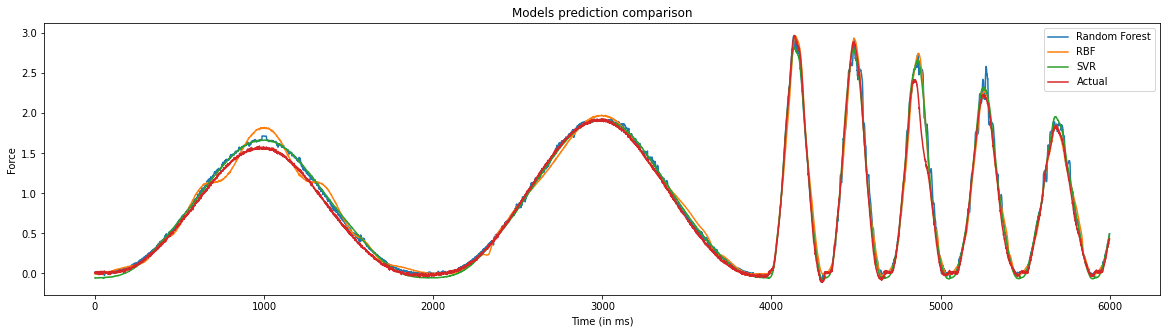

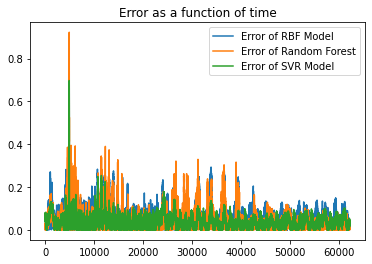

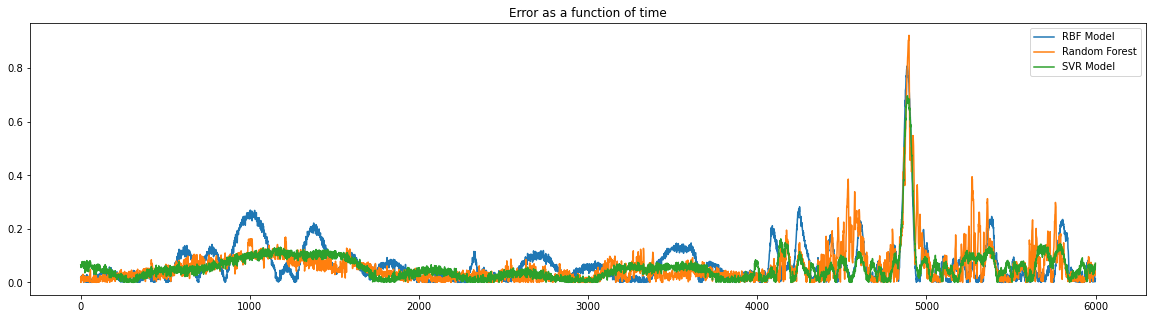

In [15]:
get_results(t=3,m=2)